# Benchmarking T5 vs. BART and Fine Tuning T5 for Custom Summarization Task
* Notebook by Adam Lang
* Date: 12/19/2024

# Extractive vs. Abstractive Summarization
* Extractive summarization is the task of extracting actual terms from the text for a summary.
* Abstractive is the process of taking the source text data and producing a summary via rephrasing or abstracting the semantic context from the text.

# Overview
* In this notebook I will do the following:
1. Benchmark a T5 model vs. BART model using a huggingface pipeline on the CNN/Daily Mail datsaet from huggingface to compare head to head the summarization capabilities of both models.
2. Fine tune a T5 model on a custom dataset.

# Install Dependencies

In [1]:
%%capture
!pip install -U transformers accelerate datasets bertviz umap-learn sentencepiece urllib3 py7zr

In [2]:
## other imports
import warnings
warnings.filterwarnings('ignore') ## filter output warnings

# Load Dataset from Hugging Face
* CNN Daily Mail dataset loaded.
* CNN/DailyMail Dataset is from huggingface.
  * dataset card: https://huggingface.co/datasets/abisee/cnn_dailymail
* The dataset itself consists of around 300,000 pairs of news articles with their respective summaries compounded from bullet points that CNN and the Daily Mail attach to their articles.
* The summaries in this well known dataset are ABSTRACTIVE not extractive.

In [3]:
## load dataset from HF
from datasets import load_dataset

## dataset
dataset = load_dataset('cnn_dailymail', '3.0.0', split="train[:10]") # load data from train split with 10 samples

README.md:   0%|          | 0.00/15.6k [00:00<?, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/259M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/34.7M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/30.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

# Exploratory Data Analysis of CNN/Daily Mail Dataset

In [4]:
## view dataset
dataset

Dataset({
    features: ['article', 'highlights', 'id'],
    num_rows: 10
})

In [5]:
## lets see first row
print("article:\n")
print(dataset[0]['article'])
print("\n\nSummary:\n")
print(dataset[0]['highlights'])

article:

LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won't cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "I don't plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an Australian interviewer earlier this month. "I don't think I'll be particularly extravagant. "The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs." At 18, Radcliffe will be able to gamble in a casino, buy a drink in a pub or see the horror film "Hostel: Part II," currently six places below his number one movie on the UK box office chart. Deta

# Benchmarking Models - T5 vs. BART summary pipelines
* Here we will compare the T5 vs. BART models on their summarization capabilities using a simple hugging face pipeline.
  * Obviously there are more detailed and more robust ways to compare these models but consider this to be an out of the box A/B test on how each model functions without fine tuning.
* T5 model I am going to use: https://huggingface.co/ubikpt/t5-small-finetuned-cnn
* BART model: https://huggingface.co/facebook/bart-large-cnn
* BART is a better model fundamentally mainly due to larger number of parameters.
  * I am not going to finetune BART here because it requires a lot of compute power.

In [6]:
## transformers pipeline
from transformers import pipeline
import torch

## device agnostic code
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

## 1. T5 summarization pipeline
summary = {}
pipe = pipeline('summarization',
                model='ubikpt/t5-small-finetuned-cnn',
                device=device)


output = pipe(dataset[0]['article'])
## get summary
summary['t5-small'] = output[0]['summary_text']


## 2. BART summarization pipeline
summary_bart = {}
pipe_bart = pipeline('summarization',
                model='facebook/bart-large-cnn',
                device=device)


output_bart = pipe_bart(dataset[0]['article'])
## get BART summary
summary_bart['bart-large'] = output_bart[0]['summary_text']

2024-12-23 14:32:34.158173: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-23 14:32:34.173829: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-23 14:32:34.178788: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-23 14:32:34.190590: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


cuda


config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/242M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

Device set to use cuda
Token indices sequence length is longer than the specified maximum sequence length for this model (638 > 512). Running this sequence through the model will result in indexing errors


config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda


In [8]:
## T5 model summary
for model in summary:
  print()
  print(f"{model} T5 model Summary:")  # Print model name for clarity
  print(summary[model])
  print()
  print(f"Length of T5 model summary: {len(summary[model])}")


## BART model summary
for model in summary_bart:
  print()
  print(f"{model} BART model Summary:") # Print model name for clarity
  print(summary_bart[model])
  print()
  print(f"Length of BART model summary: {len(summary_bart[model])}")


t5-small T5 model Summary:
Harry Potter star Daniel Radcliffe says he has no plans to fritter his cash away . The actor has filmed a TV movie about author Rudyard Kipling

Length of T5 model summary: 143

bart-large BART model Summary:
Harry Potter star Daniel Radcliffe turns 18 on Monday. He gains access to a reported £20 million ($41.1 million) fortune. Radcliffe's earnings from the first five Potter films have been held in a trust fund. Details of how he'll mark his landmark birthday are under wraps.

Length of BART model summary: 272


### Summary
* We can see the BART model summary is much longer and more detailed, almost twice as long.
* We could finetune BART but as mentioned it is a very large model and requires a lot of compute power so for experimentation purposes I will fine tune on a custom dataset using T5 which is a smaller model.

# Fine-Tuning Summarization Model on Custom Dataset

## T5-small model
* model card: https://huggingface.co/google-t5/t5-small
* 60 million parameters, so much smaller than BART and easier to fine tune with less compute power.
* The model itself was pretrained for more than summarization.
* Original arxiv paper: https://arxiv.org/abs/1910.10683
* T5 github: https://github.com/google-research/text-to-text-transfer-transformer?tab=readme-ov-file

## Custom Dataset
* Here we will use the `Samsung/samsum` dataset.
  * link: https://huggingface.co/datasets/Samsung/samsum
  * Details about the dataset direct from hugging face:
    * *The dataset contains about 16k messenger-like conversations with summaries. The conversations were created and written down by linguists fluent in English. Linguists were asked to create conversations similar to those they write on a daily basis, reflecting the proportion of topics of their real-life messenger convesations. The style and register are diversified - conversations could be informal, semi-formal or formal, they may contain slang words, emoticons and typos. Then, the conversations were annotated with summaries. It was assumed that summaries should be a concise brief of what people talked about in the conversation in third person. The SAMSum dataset was prepared by Samsung R&D Institute Poland and is distributed for research purposes (non-commercial licence: CC BY-NC-ND 4.0).*

* There are 3 main fields in the dataset we can use to fine-tune:
1. **dialogue**: text of dialogue.
2. **summary**: human written summary of the dialogue.
3. **id**: unique id of an example.

* As an industry example, you could imagine how you would use this format to create your own custom dataset to finetune. Obviously we are using this dataset from hugging face for an experiment/demo but this can be transfered to any dataset for a summarization task.




## Load Samsum Dataset

In [9]:
## load dataset
samsum = load_dataset('samsum', trust_remote_code=True)
samsum

README.md:   0%|          | 0.00/7.04k [00:00<?, ?B/s]

samsum.py:   0%|          | 0.00/3.36k [00:00<?, ?B/s]

corpus.7z:   0%|          | 0.00/2.94M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/14732 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/819 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/818 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 14732
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 818
    })
})

In [10]:
## lets view some of the train set
samsum['train'][2]

{'id': '13681000',
 'dialogue': "Tim: Hi, what's up?\r\nKim: Bad mood tbh, I was going to do lots of stuff but ended up procrastinating\r\nTim: What did you plan on doing?\r\nKim: Oh you know, uni stuff and unfucking my room\r\nKim: Maybe tomorrow I'll move my ass and do everything\r\nKim: We were going to defrost a fridge so instead of shopping I'll eat some defrosted veggies\r\nTim: For doing stuff I recommend Pomodoro technique where u use breaks for doing chores\r\nTim: It really helps\r\nKim: thanks, maybe I'll do that\r\nTim: I also like using post-its in kaban style",
 'summary': 'Kim may try the pomodoro technique recommended by Tim to get more stuff done.'}

In [11]:
## another sample of train set
samsum['train'][0]

{'id': '13818513',
 'dialogue': "Amanda: I baked  cookies. Do you want some?\r\nJerry: Sure!\r\nAmanda: I'll bring you tomorrow :-)",
 'summary': 'Amanda baked cookies and will bring Jerry some tomorrow.'}

Summary:
* It's obvious the dialogue inputs to our model are variable in length just by sampling the first few dialogue samples. This can have an significant effect on the fine tuning, so we should take a quick look at the distribution of the lenght of the dialogue samples in the training data.

## Samsum Dataset Analysis

In [12]:
## count len of dialogue
dialogue_len = [len(x['dialogue'].split()) for x in samsum['train']]

## summary len
summary_len = [len(x['summary'].split()) for x in samsum['train']]

In [14]:
%%capture 
!pip install seaborn #do this if on SageMaker

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


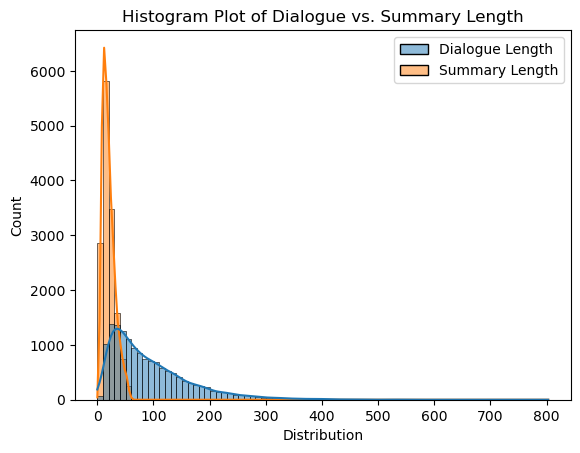

In [15]:
## create pandas df to make histogram
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

data = pd.DataFrame([dialogue_len, summary_len]).T
data.columns = ['Dialogue Length', 'Summary Length']

## histogram using seaborn
sns.histplot(data=data,kde=True,bins=80)
#data.hist(figsize=(12,8))
plt.title("Histogram Plot of Dialogue vs. Summary Length")
plt.xlabel("Distribution")
plt.show();

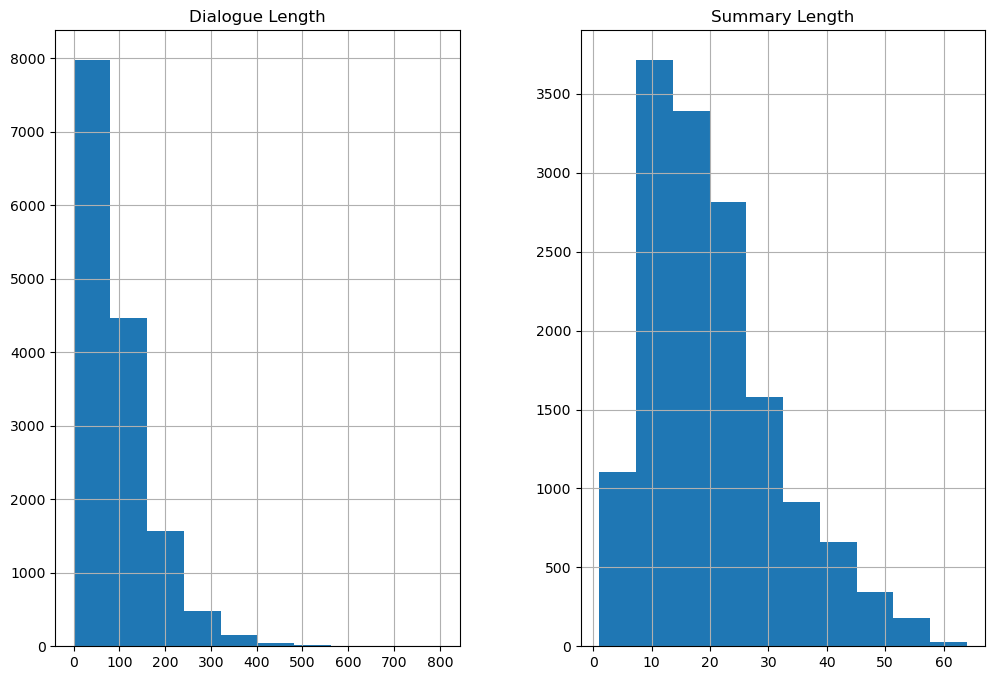

In [16]:
## matplotlib plot
data.hist(figsize=(12,8))
plt.show();

In [17]:
## lets get the stats on this
data.describe()

,Dialogue Length,Summary Length
count,14732.000000,14732.000000
mean,93.786383,20.317472
std,74.033457,11.153815
min,0.000000,1.000000
25%,39.000000,12.000000
50%,73.000000,18.000000
75%,128.000000,27.000000
max,803.000000,64.000000


Summary
* Both plots and the distribution statistics show us that for the dialogue length, the max tokens seem to be around 200.
  * This is based on the histograms but also we can see that the 3rd quartile length is 128 with a std of 74 which would be about 200.
  * Therefore I think 200 is a good cut off length for the dialogue tokens.
* We don't have to worry about the cut off length of tokens for Summary Length as they are small.

# Model Loading and Tokenization
* We will load model and tokenizer from hugging face hub.

In [18]:
## load from hf hub
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM ## sequence generation

## check device
device

device(type='cuda')

In [19]:
## define model ckpt
model_ckpt = 't5-small'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)


## init model
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt)

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [20]:
## lets see model params
model

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

## Tokenization

In [21]:
## tokenizer test
tokenizer(samsum['train'][0]['dialogue'], text_target=samsum['train'][0]['summary'],
          return_tensors='pt')

{'input_ids': tensor([[21542,    10,    27, 13635,  5081,     5,   531,    25,   241,   128,
            58, 16637,    10, 10625,    55, 21542,    10,    27,    31,   195,
           830,    25,  5721,     3,    10,    18,    61,     1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]]), 'labels': tensor([[21542, 13635,  5081,    11,    56,   830, 16637,   128,  5721,     5,
             1]])}

In [22]:
## write function for tokenization
def tokenize_data(batch):
  """Function to tokenize text data"""
  encoding = tokenizer(batch['dialogue'],
                       text_target=batch['summary'],
                       max_length=200, ## I based this on histogram above
                       truncation=True,
                       padding=True,
                       return_tensors='pt')

  return encoding

In [23]:
## map tokenizer to dataset
samsum_pt = samsum.map(tokenize_data,
                       batched=True,
                       batch_size=None)

Map:   0%|          | 0/14732 [00:00<?, ? examples/s]

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

In [25]:
## lets see the output
samsum_pt

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 14732
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 818
    })
})

# T5 Model Training
* A note about `gradient_accumulation_steps` below:
  * For every training epoch the gradient is calculated.
  * Based on that, model weights are modified.
  * Ideally, you want to update the model weights more frequently than every 500 steps.
  * Excellent review article on this: https://medium.com/@harshit158/gradient-accumulation-307de7599e87

## Gradient Accumulation Breakdown:
* When we train a neural network it usually follows this workflow. On every mini-batch:

1. Run the forward pass while storing the activations.

2. During backward pass:

  * Compute the loss

  * Compute the gradients

  * Update the weights

* Gradient accumulation **modifies the last step of the backward pass, i.e., weight updates.**

* More specifically, instead of updating the weights on every mini-batch, we can do this:

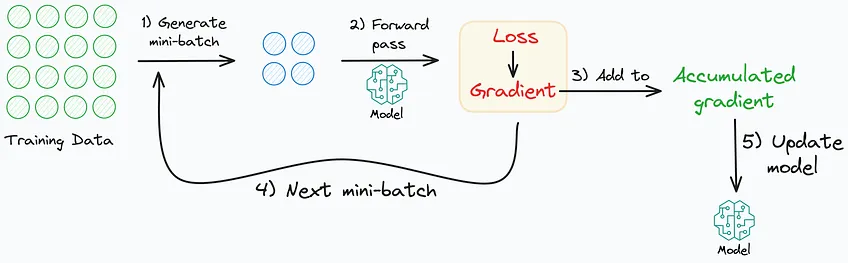

The steps WITH Gradient Accumulation now look like this:
1. Run the forward pass on a mini-batch.

2. Compute the gradient values for weights in the network.

3. **DO NOT update the weights yet.**

4. Run the forward pass on the **next mini-batch.**

5. Compute the gradient values for weights and add them to the gradients obtained in step 2.

6. Repeat steps 3-5 for a few more mini-batches.

7. Update the weights only after processing a few mini-batches.

* This technique works well because accumulating the gradients across multiple mini-batches **results in the same sum of gradients as if we were processing them together.**

* Thus, logically speaking, using gradient accumulation, we can mimic a larger batch size without having to explicitly increase the batch size.


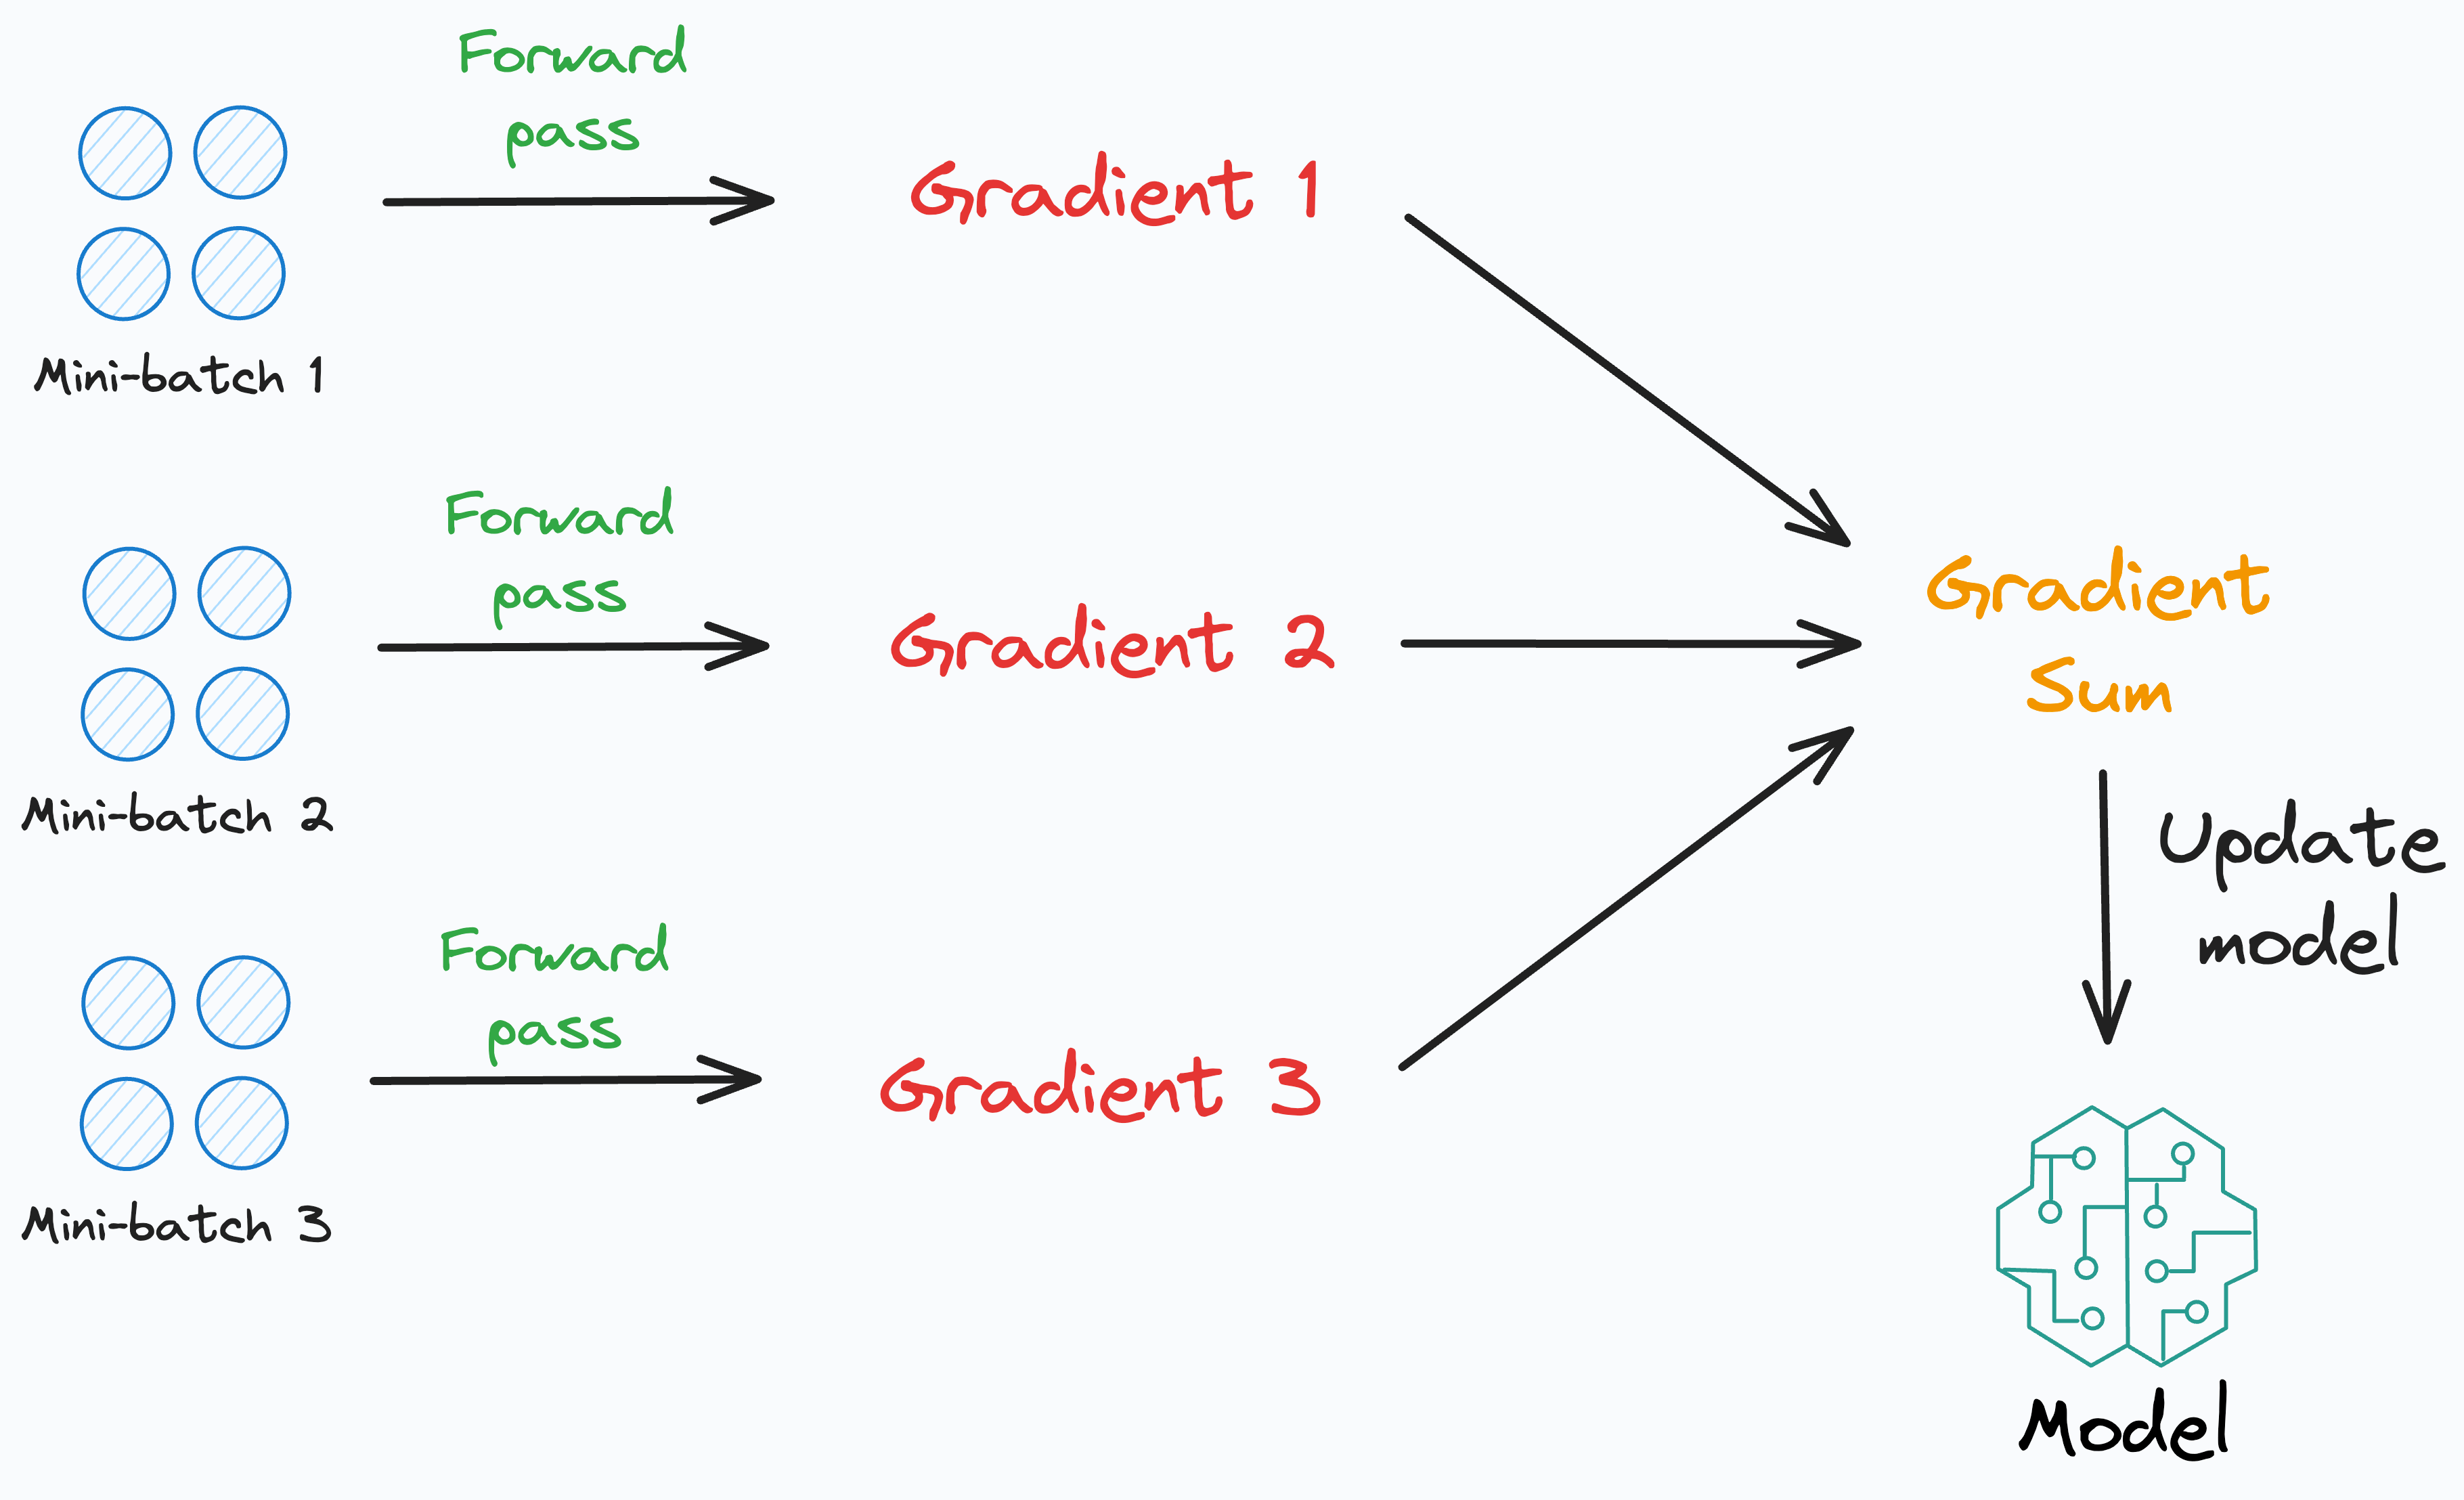

* As an example, lets say we want to use a **batch size of 64**. However, current memory can only support a batch size of 16.

* This is where Gradient Accumulation comes to the rescue! We can use a batch size of size 16.

  * We can accumulate the gradients from every mini-batch.

  * We can update the weights only once every 8 mini-batches.

  * Thus, effectively, we used a batch size of 16*8 (=128) instead of what we originally intended — 64.

Source: https://blog.dailydoseofds.com/p/gradient-accumulation-increase-batch

In [26]:
## imports
from transformers import DataCollatorForSeq2Seq
from transformers import TrainingArguments, Trainer

## setup data collator
data_collator = DataCollatorForSeq2Seq(tokenizer,
                                       model=model)

In [28]:
## training arguments
args = TrainingArguments(
    output_dir="train_dir", #most important param
    num_train_epochs=2,
    per_device_train_batch_size=4, # 4 batches trained on GPU
    per_device_eval_batch_size=4,  # 4 batches eval on GPU
    eval_strategy='epoch',
    save_strategy='epoch',
    weight_decay=0.01,
    learning_rate=2e-5,
    gradient_accumulation_steps=500,

)

#initialize trainer
trainer = Trainer(model=model,
                  args=args,
                  tokenizer=tokenizer,
                  data_collator=data_collator,
                  train_dataset=samsum_pt['train'],
                  eval_dataset=samsum_pt['validation'],
                  )

In [29]:
## now train the model
trainer.train()

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss
1,No log,13.790565


TrainOutput(global_step=14, training_loss=6720.953125, metrics={'train_runtime': 279.3718, 'train_samples_per_second': 105.465, 'train_steps_per_second': 0.05, 'total_flos': 1413264467558400.0, 'train_loss': 6720.953125, 'epoch': 1.8145533532446376})

# Save Model

In [30]:
## save model
trainer.save_model('t5_samsum_summarization')

# Predictions
* Here we will make our predictions using the Hugging Face Pipeline.

In [31]:
from transformers import pipeline

In [32]:
## create pipeline for predictions 
pipe = pipeline('summarization', model='t5_samsum_summarization', device=device) 


## test dialogue -- I generated synthetic conversation using Claude Sonnet 
custom_dialogue = """
Jim: Hey Abigail, I'm thinking about taking a trip next month. Have you bought plane tickets recently?


Abigail: Hi Jim! Yes, I actually just booked a flight last week. Where are you planning to go?


Jim: I'm considering a trip to Barcelona. How was your experience with booking?


Abigail: It was pretty straightforward. I used a comparison site to find the best deals. Have you checked any of those yet?


Jim: Not yet. Which one did you use? I've heard there are quite a few options.


Abigail: I used Skyscanner. It lets you compare prices across different airlines and dates. Really helpful for finding good deals.


Jim: That sounds useful. Did you find any good tricks for getting cheaper tickets?


Abigail: Actually, yes! I found that flying on a Tuesday or Wednesday was significantly cheaper than weekend flights.


Jim: Oh, that's good to know. I'll keep that in mind. How far in advance did you book?


Abigail: I booked about two months ahead. Generally, I've heard booking 6-8 weeks in advance often gets you the best prices.


Jim: Interesting. What about luggage? Did you go for a carry-on only or checked baggage?


Abigail: I went for carry-on only. Many budget airlines charge extra for checked bags, so I saved some money there.


Jim: Smart move. One last thing - did you get travel insurance?


Abigail: Yes, I did. With all the uncertainties these days, I thought it was worth the extra cost for peace of mind.


Jim: That makes sense. Thanks for all the tips, Abigail. You've been really helpful!


Abigail: Happy to help, Jim! Good luck with your booking, and enjoy your trip to Barcelona if you decide to go!


Jim: Thanks! I'll let you know how it goes with the booking.


Abigail: Please do! And don't forget to share some photos from your trip!
"""

Device set to use cuda


In [33]:
len(custom_dialogue)

1778

In [51]:
output

[{'summary_text': 'Abigail: I used a comparison site to find the best deals . he says booking 6-8 weeks in advance often gets you the best prices . "you\'ve been really helpful! I\'m thinking about taking a trip to Barcelona"'}]

In [53]:
## print output
output = pipe(custom_dialogue)


from IPython.display import display, Markdown
display(Markdown(output[0]['summary_text']))

Abigail: I used a comparison site to find the best deals . he says booking 6-8 weeks in advance often gets you the best prices . "you've been really helpful! I'm thinking about taking a trip to Barcelona"